# Brain Tumor Classification

### 1. Dataset Overview
This project combines multiple public brain tumor MRI image datasets to build a 3-class classifier for:
- **Glioma**  
- **Meningioma**  
- **Pituitary Tumor**  

### Class Definitions
| Class          | Description |
|----------------|-------------|
| **Glioma**     | Tumors originating from glial cells; includes astrocytomas, oligodendrogliomas, and glioblastomas. |
| **Meningioma** | Benign tumors arising from the meninges (outer layers of the brain). |
| **Pituitary Tumor** | Usually benign tumors that develop in the pituitary gland at the base of the brain. |


### 2. Class Distributions
Before training, we’ll examine the sample counts across all datasets and visualize the overall distribution.


{'glioma': 2004, 'meningioma': 2004, 'pituitary': 2048}


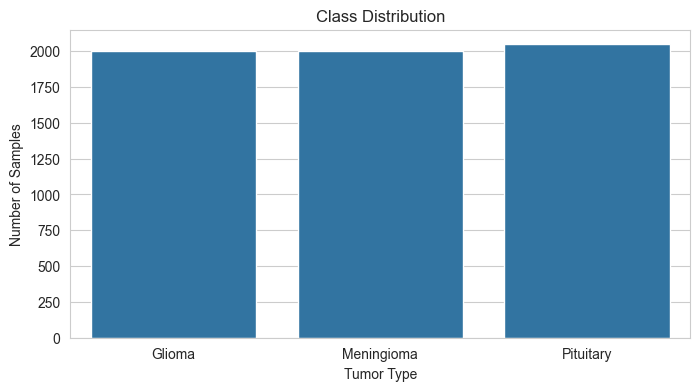

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

# define path
data_dir = Path("..") / "data" / "raw"

# count samples
def count_samples(directory):
    return {
        cls: len(os.listdir(os.path.join(directory, cls))) 
        for cls in os.listdir(directory) 
        if os.path.isdir(os.path.join(directory, cls))
    }

# get counts
counts = count_samples(data_dir)
print(counts)

# name cols
counts['Glioma'] = counts.pop('glioma')
counts['Meningioma'] = counts.pop('meningioma')
counts['Pituitary'] = counts.pop('pituitary')

# convert to dataframe
df = pd.DataFrame(list(counts.items()), columns=["Tumor Type", "Count"])

# plot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 4))
sns.barplot(x="Tumor Type", y="Count", data=df)
plt.title("Class Distribution")
plt.ylabel("Number of Samples")
plt.xlabel("Tumor Type")

# ensure folder exists
os.makedirs("../graphics", exist_ok=True)
plt.savefig("../graphics/class_distribution.png", bbox_inches="tight")
plt.show()

From what we can see above:
- Tumor classes contain the following sample counts:  
  - Glioma: 2004  
  - Meningioma: 2004 
  - Pituitary: 2048  
- There is little to none class imbalance, with all three classes being close to each other.
- No oversampling or class weighting is required.



### 3. Image Quality

To ensure our model learns meaningul patterns from the input images, we need to make sample visualizations

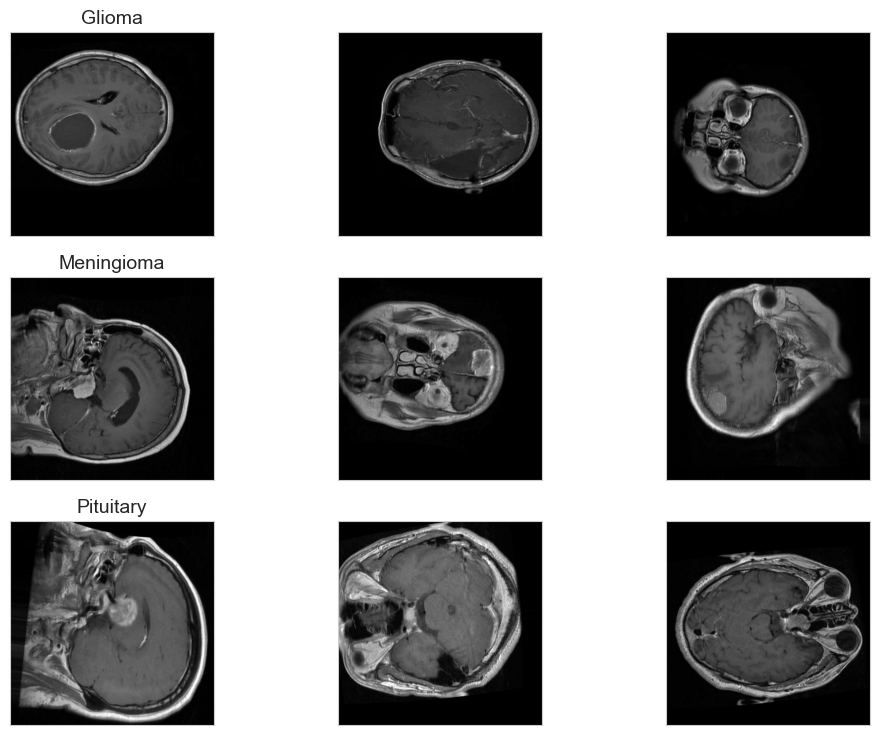

In [12]:
# seed for reproducibility
np.random.seed(55)

# load random images from a class
def load_n_images(class_name, n=3):
    return [Image.open(os.path.join(data_dir, class_name, f)).convert("L")
            for f in np.random.choice(os.listdir(os.path.join(data_dir, class_name)), size=n, replace=False)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))]

# load 3 images per class
glioma_imgs = load_n_images("glioma", n=3)
meningioma_imgs = load_n_images("meningioma", n=3)
pituitary_imgs = load_n_images("pituitary", n=3)

# plot all images (3 rows × 3 columns)
fig, axes = plt.subplots(3, 3, figsize=(12, 9))

# glioma row
for i, img in enumerate(glioma_imgs):
    axes[0, i].imshow(img, cmap="gray")
    if i == 0:
        axes[0, i].set_title("Glioma", fontsize=14)

# meningioma row
for i, img in enumerate(meningioma_imgs):
    axes[1, i].imshow(img, cmap="gray")
    if i == 0:
        axes[1, i].set_title("Meningioma", fontsize=14)

# pituitary row
for i, img in enumerate(pituitary_imgs):
    axes[2, i].imshow(img, cmap="gray")
    if i == 0:
        axes[2, i].set_title("Pituitary", fontsize=14)

# remove ticks
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

# save figure
plt.savefig("../graphics/class_examples.png", bbox_inches="tight")
plt.show()


Looking at the plotted images:

- All images appear to have similar contrast and uniform size.
- Variations in tumor location and scanning angle will help the model learn diverse features.


### 4. Model Plan

The model setup for this project will include:

- **Transfer learning**  
  Use a ResNet50 backbone pretrained on RadImageNet and replace the final classification head for tumor-type prediction. 

- **AutoAugment**  
  Automatically applies a set of learned augmentation policies (rotations, color/brightness changes, crops, etc.) to increase data diversity and reduce overfitting.

- **Efficient data loading**  
  Use `DataLoader` with an appropriate `batch_size`, `num_workers`, `pin_memory`, and `persistent_workers` so disk I/O and preprocessing don’t bottleneck GPU training.

- **Mixed precision training**  
  Use `torch.cuda.amp` to speed up training and reduce memory usage by computing in float16 where safe.

- **Optimizer & weight decay**  
  Use a modern optimizer with weight decay to help generalization by penalizing large weights.

- **Learning rate scheduling**  
  Use a scheduler to vary the learning rate during training — helps faster convergence and better final performance.

- **Dropout**  
  Apply dropout in the classifier head to reduce overfitting by randomly deactivating neurons during training.

- **Checkpointing & early stopping**  
  Save best model checkpoints based on validation performance and stop training if metrics plateau to prevent overfitting.

- **Metrics & epoch stats**  
  Track training/validation loss, accuracy, and **macro F1** each epoch, plus per-class precision/recall and a confusion matrix for error analysis.

- **Grad-CAM**  
  Visualize model attention maps on example images to verify that the network focuses on clinically relevant regions.
